# ATOC NWP: evaluating potential temperatrues due to difference PBL schemes

October 11, 2021

Modified from a stack of other notebooks....

# 0.0 Import all the modules

In [18]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import matplotlib.units as munits
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

from scipy.optimize import curve_fit
# from netCDF4 import Dataset
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime


print('Done importing modules now')

import warnings
warnings.filterwarnings('ignore')

# Make sure the environment is good ** especially important if running on another machines
import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES, extract_global_attrs)
import matplotlib.style as style
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps


Done importing modules now


This notebook assumes that your data is located in WRF_DIRECTORY. If you used a different directory structure, you will need to modify it.

In [19]:
WRF_DIRECTORY = '/projects/jiko1138/ATOC_NWP/ICA_06/'
DIR_1 = 'e_vert33/'
DIR_2 = 'Katrina_sd/'
DIR_3 = 'e_vert73_eta_levels/'

### 1.0 Make the terrain map of the domain.

In [20]:
DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + DIR_2 + "/wrfout_d01_2005-08-28_15:00:00")
DIR_1_d02 = xr.open_dataset(WRF_DIRECTORY + DIR_2 + "/wrfout_d01_2005-08-28_15:00:00")

print('Reading ' + DIR_2 + ' for mapping')

Reading Katrina_sd/ for mapping


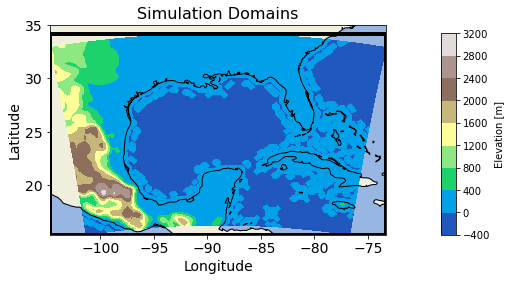

In [21]:
### Useful data and parameters for plotting


# Figure out the location we care about
desired_lon = -105.0038
desired_lat = 40.05


## Pull lat/lon from the dataset
lats1 = DIR_1_d01['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs1 = DIR_1_d01['XLONG'].isel(Time=0)
hgt1 = DIR_1_d01['HGT'].isel(Time=0)
lats2 = DIR_1_d02['XLAT'].isel(Time=0)
longs2 = DIR_1_d02['XLONG'].isel(Time=0)
hgt2 = DIR_1_d02['HGT'].isel(Time=0)

## Extract min/max values if you chose to bound the size of the map
min_lat1 = lats1.values.min()
max_lat1 = lats1.values.max()
min_lon1 = longs1.values.min()
max_lon1 = longs1.values.max()
MAP_BOUNDS1 = [min_lon1, max_lon1, min_lat1, max_lat1]
min_lat2 = lats2.values.min()
max_lat2 = lats2.values.max()
min_lon2 = longs2.values.min()
max_lon2 = longs2.values.max()
MAP_BOUNDS2 = [min_lon2, max_lon2, min_lat2, max_lat2]

# Create figure and axes objects
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines
ax.set_extent(MAP_BOUNDS1)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)

# Draw bounding box for inner domain
ax.plot((min_lon2, min_lon2), (min_lat2, max_lat2), lw=4, color='k')
ax.plot((max_lon2, max_lon2), (min_lat2, max_lat2), lw=4, color='k')
ax.plot((min_lon2, max_lon2), (min_lat2, min_lat2), lw=4, color='k')
ax.plot((min_lon2, max_lon2), (max_lat2, max_lat2), lw=4, color='k')

im=ax.contourf(DIR_1_d01['XLONG'].values[0, :, :],
    DIR_1_d01['XLAT'].values[0, :, :],
    DIR_1_d01['HGT'].values[0, :, :], #c_levels,
    cmap=plt.cm.terrain,projection=ccrs.PlateCarree())

#### Projection is messed up here - figure out how to fix this!

# Add important info to the plot
ax.set_title("Simulation Domains", fontsize=16)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)

ax.scatter([desired_lon], [desired_lat], color='r') # Dot for location of BAO

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Elevation [m]")

# Adjust figure height so the xlabel isn't cut off when saved
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("domain.png")
plt.savefig("domain.pdf")

plt.show()

In [22]:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

Now read in all the files and the appropriate data from each of the files

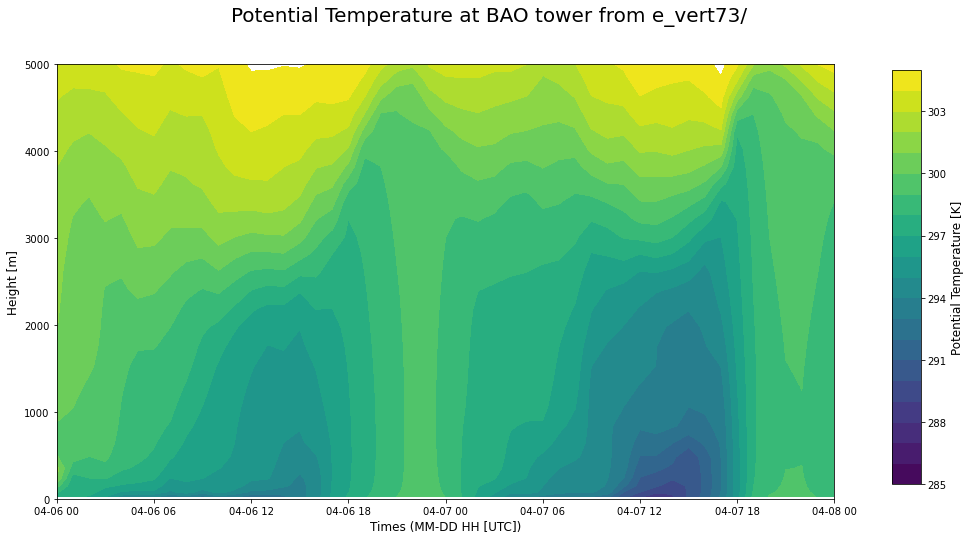

In [8]:
gtemp_73s  = gtemp_73[:,:,ind_max_s[0],ind_max_s[1]]
gtemp_73st = np.transpose(gtemp_73s)

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(285, 306, 1)

im = ax.contourf(
    Times,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    gtemp_73st+290, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Potential Temperature at BAO tower from " + DIR_TO_PLOT, fontsize=20)

ax.set_xlabel("Times (MM-DD HH [UTC])", fontsize=12)
ax.set_ylabel("Height [m]", fontsize=12)
ax.set_ylim(0,5000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Potential Temperature [K]", fontsize=12)

end = DIR_TO_PLOT.find('/', 0)
# print(end)
# print(DIR_TO_PLOT[0:end])
DIR_TO_PLOT_WITHOUT_SLASH = DIR_TO_PLOT[0:end]

plt.savefig("pt_contour_" + DIR_TO_PLOT_WITHOUT_SLASH + ".png")

plt.show()

(49, 32, 81, 99)
(49, 32)
(32, 49)
(32, 49)


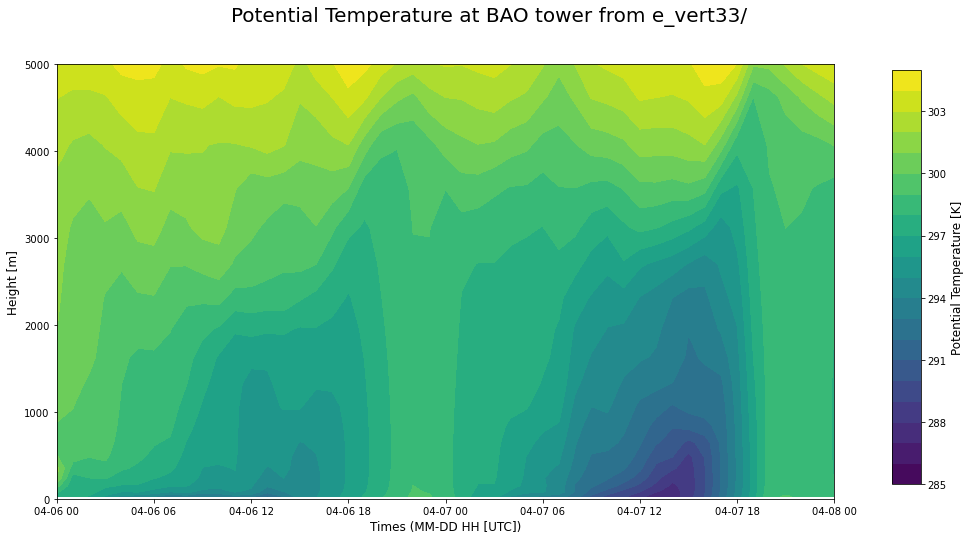

In [18]:
print(np.shape(gtemp_33))
gtemp_33s  = gtemp_33[:,:,ind_max_s[0],ind_max_s[1]]
gtemp_33st = np.transpose(gtemp_33s)

print(np.shape(gtemp_33s))
print(np.shape(gtemp_33st))
print(np.shape(windst))

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(285, 306, 1)

im = ax.contourf(
    Times,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    gtemp_33st+290, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Potential Temperature at BAO tower from " + DIR_TO_PLOT, fontsize=20)

ax.set_xlabel("Times (MM-DD HH [UTC])", fontsize=12)
ax.set_ylabel("Height [m]", fontsize=12)
ax.set_ylim(0,5000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Potential Temperature [K]", fontsize=12)

end = DIR_TO_PLOT.find('/', 0)
# print(end)
# print(DIR_TO_PLOT[0:end])
DIR_TO_PLOT_WITHOUT_SLASH = DIR_TO_PLOT[0:end]

plt.savefig("pt_contour_" + DIR_TO_PLOT_WITHOUT_SLASH + ".png")

plt.show()

(49, 81, 99)
(49, 81, 99)
(49, 81, 99)


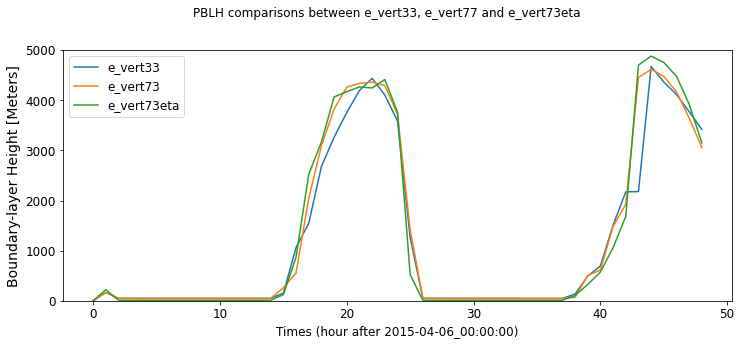

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

print(np.shape(pblh_33))
print(np.shape(pblh_73))
print(np.shape(pblh_73eta))

time_axis = xtime

ax.plot(time_axis/60, pblh_33[:,ind_max_s[0],ind_max_s[1]], label='e_vert33')
ax.plot(time_axis/60, pblh_73[:,ind_max_s[0],ind_max_s[1]], label='e_vert73')
ax.plot(time_axis/60, pblh_73eta[:,ind_max_s[0],ind_max_s[1]], label='e_vert73eta')

ax.legend(fontsize=12)
plt.suptitle("PBLH comparisons between e_vert33, e_vert77 and e_vert73eta", fontsize=12)
ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")", fontsize=12)
ax.set_ylabel("Boundary-layer Height [Meters]", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim(0,5000)

# Format the x-axis labels nicely
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig("timeseries_pblh.png")

plt.show()

(49, 81, 99)
(49, 81, 99)
(49, 81, 99)


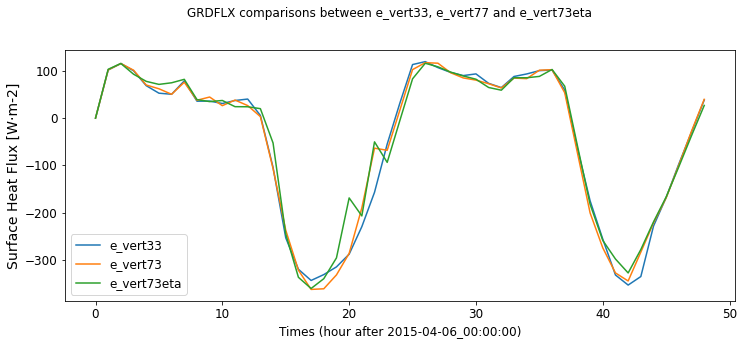

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

print(np.shape(pblh_33))
print(np.shape(pblh_73))
print(np.shape(pblh_73eta))

time_axis = xtime
plt.suptitle("GRDFLX comparisons between e_vert33, e_vert77 and e_vert73eta", fontsize=12)
ax.plot(time_axis/60, GRDFLX_33[:,ind_max_s[0],ind_max_s[1]], label='e_vert33')
ax.plot(time_axis/60, GRDFLX_73[:,ind_max_s[0],ind_max_s[1]], label='e_vert73')
ax.plot(time_axis/60, GRDFLX_73eta[:,ind_max_s[0],ind_max_s[1]], label='e_vert73eta')

ax.legend(fontsize=12)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")", fontsize=12)
ax.set_ylabel("Surface Heat Flux [W·m-2]", fontsize=14)
ax.tick_params(labelsize=12)

# Format the x-axis labels nicely
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig("timeseries_GRDFLX.png")

plt.show()